# 시계열 데이터 처리 Mini Project

### Air Passenger  
비정상 데이터를 정상 데이터로 만들기

In [1]:
# 라이브러리
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 데이터 불러오기
ap = pd.read_csv('./AirPassengers.csv')

In [3]:
ap.drop('Month', axis = 1, inplace = True)

In [4]:
ap

#Passengers
0            112
1            118
2            132
3            129
4            121
..           ...
139          606
140          508
141          461
142          390
143          432

[144 rows x 1 columns]

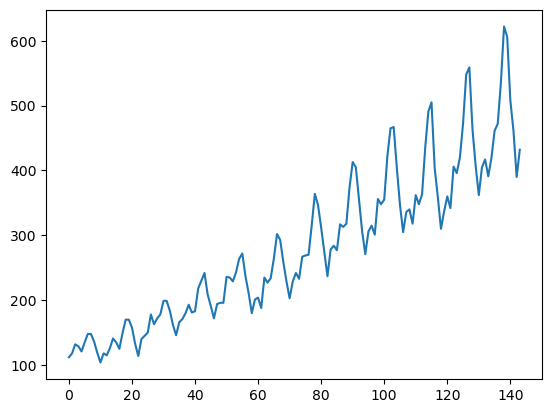

In [5]:
plt.figure()
plt.plot(ap)
plt.show()

시각적 분석: 트렌드(추세), 계절성을 높이 띄므로 완벽한 비정상 데이터라고 판단됨.   
따라서 분산, 추세와 계절성을 없앨 수 있도록 로그 변환과 차분을 진행해야 함.

분산을 일정하게 만들기

log transformation

In [6]:
log_transformed = np.log(ap)

In [7]:
log_transformed

#Passengers
0       4.718499
1       4.770685
2       4.882802
3       4.859812
4       4.795791
..           ...
139     6.406880
140     6.230481
141     6.133398
142     5.966147
143     6.068426

[144 rows x 1 columns]

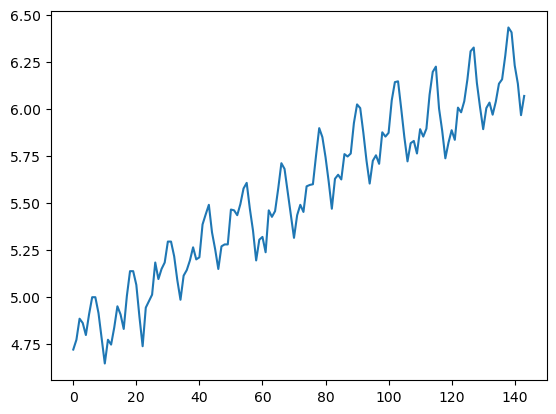

In [8]:
plt.figure()
plt.plot(log_transformed)
plt.show()

차분을 통해 추세 제거하기   
(차분을 하면 데이터가 줄어듦, 앞쪽에 null값이 발생하므로 주의)

In [9]:
diffed = log_transformed.diff()[1:]

In [10]:
diffed

#Passengers
1       0.052186
2       0.112117
3      -0.022990
4      -0.064022
5       0.109484
..           ...
139    -0.026060
140    -0.176399
141    -0.097083
142    -0.167251
143     0.102279

[143 rows x 1 columns]

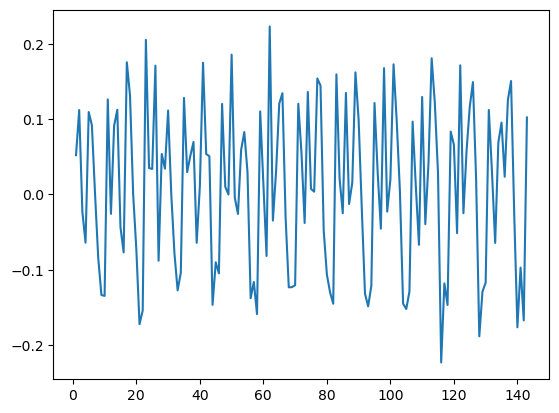

In [11]:
plt.figure()
plt.plot(diffed)
plt.show()

계절 차분을 통해 계절성 제거하기

In [12]:
seasonally_diffed = diffed.diff(12) # diff에 12를 넣어주면, 주기를 12로 하는 계절 차분이 수행됨

In [13]:
seasonally_diffed.head(20)

#Passengers
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
6           NaN
7           NaN
8           NaN
9           NaN
10          NaN
11          NaN
12          NaN
13     0.039164
14     0.000361
15    -0.020496
16    -0.012939
17     0.066148
18     0.039915
19     0.000000
20     0.011354

In [14]:
# 차분을 한 후에는 null 값을 반드시 삭제해줘야함. 
seasonally_diffed.dropna(inplace = True)

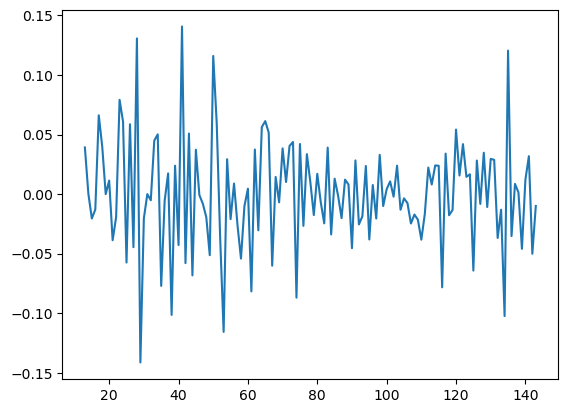

In [15]:
plt.figure()
plt.plot(seasonally_diffed)
plt.show()

검정을 통해 정상성 확인하기

In [16]:
from statsmodels.tsa.stattools import adfuller # ADF = 귀무가설 비정상

In [17]:
def adf_test(x): # adf 검정 위한 함수 정의
    stat, p_value, lags, nobs, crit, icb = adfuller(x) # adf 6개 output
    print('ADF statistics')
    print(stat) # ADF 검정 통계량 표시
    print('P-value')
    print(p_value) # P-value 표시

In [18]:
adf_test(seasonally_diffed) # 계절 차분 완료한 데이터로 adf 테스트 수행

ADF statistics
-4.443324941831145
P-value
0.00024859123113838257


P-value가 0.01 또는 0.05 보다 작아서 귀무가설(비정상)이 기각되므로 ADF에 의하면 데이터는 정상적

시계열 분류

Logistic Regression 이용했을 때 낮은 score 발생했으므로, 다른 방법 진행

### Robot Failures

In [19]:
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures

In [20]:
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

In [21]:
# id, time 제외하고 6개의  column의 X변수가 나타남
timeseries

id  time  F_x  F_y  F_z  T_x  T_y  T_z
0      1     0   -1   -1   63   -3   -1    0
1      1     1    0    0   62   -3   -1    0
2      1     2   -1   -1   61   -3    0    0
3      1     3   -1   -1   63   -2   -1    0
4      1     4   -1   -1   63   -3   -1    0
...   ..   ...  ...  ...  ...  ...  ...  ...
1315  88    10  -10    2   39  -21  -24    5
1316  88    11  -11    2   38  -24  -22    6
1317  88    12  -12    3   23  -24  -24    5
1318  88    13  -13    4   26  -29  -27    5
1319  88    14  -13    2   15  -25  -25    6

[1320 rows x 8 columns]

In [22]:
# target인 true/false가 제시
y

1      True
2      True
3      True
4      True
5      True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 88, dtype: bool

In [23]:
def custom_classification_split(x, y, test_size=0.3):
    num_true = int(y.sum()*test_size)
    num_false = int((len(y)-y.sum())*test_size)

    id_list = y[y==False].head(num_false).index.to_list() + y[y==True].head(num_true).index.to_list()

    y_train = y.drop(id_list)
    y_test = y.iloc[id_list].sort_index()
    X_train = timeseries[~timeseries['id'].isin(id_list)]
    X_test = timeseries[timeseries['id'].isin(id_list)]

    return X_train, y_train, X_test, y_test
    

In [24]:
X_train, y_train, X_test, y_test = custom_classification_split(timeseries, y, test_size = 0.25)

EfficientParameters: 큰 계산비용이 필요한 calculator를 제외하고 가능한 모든 특징 생성

In [25]:
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute

settings = EfficientFCParameters()

In [26]:
comprehensive_features_train = extract_features(
                                X_train,
                                column_id="id",
                                column_sort="time",
                                default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


In [27]:
comprehensive_features_test = extract_features(
                                X_test,
                                column_id="id",
                                column_sort="time",
                                default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 18/18 [00:07<00:00,  2.49it/s]


impute를 통해 데이터 전처리 (특징 추출된 모든 값을 동일한 열의 중앙/극단값으로 바꿈)

In [28]:
impute(comprehensive_features_train)

c:\Users\User\anaconda3\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


F_x__variance_larger_than_standard_deviation  F_x__has_duplicate_max  \
6                                            1.0                     1.0   
7                                            0.0                     1.0   
8                                            1.0                     0.0   
9                                            1.0                     0.0   
10                                           0.0                     0.0   
..                                           ...                     ...   
84                                           1.0                     1.0   
85                                           1.0                     0.0   
86                                           1.0                     0.0   
87                                           1.0                     1.0   
88                                           1.0                     0.0   

    F_x__has_duplicate_min  F_x__has_duplicate  F_x__sum_values  \
6                      1.0                 1.0            -15.0   
7                      0.0                 1.0            -13.0   
8                      1.0                 1.0            -10.0   
9                      0.0                 1.0            -10.0   
10                     1.0                 1.0            -14.0   
..                     ...                 ...              ...   
84                     0.0                 1.0          -1073.0   
85                     1.0                 1.0            143.0   
86                     0.0                 0.0            961.0   
87                     0.0                 1.0           4509.0   
88                     1.0                 1.0           -143.0   

    F_x__abs_energy  F_x__mean_abs_change  F_x__mean_change  \
6              39.0              1.714286          0.142857   
7              21.0              0.928571          0.214286   
8              26.0              1.142857         -0.142857   
9              24.0              1.428571          0.000000   
10             14.0              0.142857          0.000000   
..              ...                   ...               ...   
84          96833.0              7.142857         -5.428571   
85           1683.0              1.357143          1.071429   
86          83497.0              9.071429          9.071429   
87        1405437.0             12.928571         12.214286   
88           1427.0              0.785714         -0.500000   

    F_x__mean_second_derivative_central  F_x__median  ...  \
6                              0.153846         -1.0  ...   
7                             -0.076923         -1.0  ...   
8                              0.192308         -1.0  ...   
9                             -0.076923         -1.0  ...   
10                             0.000000         -1.0  ...   
..                                  ...          ...  ...   
84                            -0.038462        -98.0  ...   
85                             0.076923          8.0  ...   
86                             0.807692         52.0  ...   
87                            -1.038462        338.0  ...   
88                             0.038462         -9.0  ...   

    T_z__fourier_entropy__bins_5  T_z__fourier_entropy__bins_10  \
6                       0.974315                       1.213008   
7                       1.255482                       1.494175   
8                       1.494175                       1.732868   
9                       1.255482                       1.494175   
10                      0.937285                       1.213008   
..                           ...                            ...   
84                      0.735622                       0.735622   
85                      0.735622                       0.735622   
86                      0.735622                       1.073543   
87                      0.735622                       0.735622   
88                      1.255482                       1.49

In [29]:
comprehensive_features_train.head() # 다시 정의해주지 않아도 impute는 적용되는 걸로 보임

F_x__variance_larger_than_standard_deviation  F_x__has_duplicate_max  \
6                                            1.0                     1.0   
7                                            0.0                     1.0   
8                                            1.0                     0.0   
9                                            1.0                     0.0   
10                                           0.0                     0.0   

    F_x__has_duplicate_min  F_x__has_duplicate  F_x__sum_values  \
6                      1.0                 1.0            -15.0   
7                      0.0                 1.0            -13.0   
8                      1.0                 1.0            -10.0   
9                      0.0                 1.0            -10.0   
10                     1.0                 1.0            -14.0   

    F_x__abs_energy  F_x__mean_abs_change  F_x__mean_change  \
6              39.0              1.714286          0.142857   
7              21.0              0.928571          0.214286   
8              26.0              1.142857         -0.142857   
9              24.0              1.428571          0.000000   
10             14.0              0.142857          0.000000   

    F_x__mean_second_derivative_central  F_x__median  ...  \
6                              0.153846         -1.0  ...   
7                             -0.076923         -1.0  ...   
8                              0.192308         -1.0  ...   
9                             -0.076923         -1.0  ...   
10                             0.000000         -1.0  ...   

    T_z__fourier_entropy__bins_5  T_z__fourier_entropy__bins_10  \
6                       0.974315                       1.213008   
7                       1.255482                       1.494175   
8                       1.494175                       1.732868   
9                       1.255482                       1.494175   
10                      0.937285                       1.213008   

    T_z__fourier_entropy__bins_100  \
6                         1.732868   
7                         2.079442   
8                         2.079442   
9                         2.079442   
10                        1.906155   

    T_z__permutation_entropy__dimension_3__tau_1  \
6                                       1.438883   
7                                       1.043794   
8                                       1.412745   
9                                       1.479133   
10                                     -0.000000   

    T_z__permutation_entropy__dimension_4__tau_1  \
6                                       1.863680   
7                                       1.349792   
8                                       2.138333   
9                                       2.138333   
10                                     -0.000000   

    T_z__permutation_entropy__dimension_5__tau_1  \
6                                       2.145842   
7                                       1.666333   
8                                       2.397895   
9                                       2.397895   
10                                     -0.000000   

    T_z__permutation_entropy__dimension_6__tau_1  \
6                                       2.163956   
7                                       1.748067   
8                                       2.302585   
9                                       2.302585   
10                                     -0.000000   

    T_z__permutation_entropy__dimension_7__tau_1  \
6                                       2.197225   
7                                       1.831020   
8                                       2.197225   
9                                       2.197225   
10                                     -0.000000   

    T_z__query_similarity_count__query_None__threshold_0.0  \
6                                                 0.0        
7                                                 0.0        
8              

In [30]:
# lR을 수행했더니 NaN이 발생한다고 해서 test 데이터도 impute를 진행 (강의에서는 train만 impute를 했던 걸로 나는 기억했는데, 다른 그루분들은 강의에서 train도 impute하셨다고 함.)
impute(comprehensive_features_test)

c:\Users\User\anaconda3\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


F_x__variance_larger_than_standard_deviation  F_x__has_duplicate_max  \
1                                            0.0                     0.0   
2                                            0.0                     1.0   
3                                            0.0                     0.0   
4                                            0.0                     1.0   
5                                            0.0                     0.0   
19                                           1.0                     0.0   
20                                           1.0                     0.0   
21                                           1.0                     0.0   
22                                           1.0                     0.0   
23                                           1.0                     0.0   
24                                           1.0                     0.0   
25                                           1.0                     0.0   
26                                           1.0                     0.0   
27                                           1.0                     1.0   
28                                           1.0                     0.0   
29                                           1.0                     0.0   
30                                           1.0                     0.0   
31                                           1.0                     0.0   
32                                           1.0                     0.0   
33                                           1.0                     0.0   
34                                           1.0                     0.0   

    F_x__has_duplicate_min  F_x__has_duplicate  F_x__sum_values  \
1                      1.0                 1.0            -14.0   
2                      1.0                 1.0            -13.0   
3                      1.0                 1.0            -10.0   
4                      1.0                 1.0             -6.0   
5                      0.0                 1.0             -9.0   
19                     0.0                 1.0             99.0   
20                     1.0                 1.0            155.0   
21                     0.0                 1.0           -171.0   
22                     0.0                 1.0            102.0   
23                     0.0                 1.0             67.0   
24                     0.0                 1.0           -338.0   
25                     0.0                 1.0           -123.0   
26                     0.0                 1.0            -63.0   
27                     0.0                 1.0             50.0   
28                     0.0                 1.0            -28.0   
29                     0.0                 1.0            -51.0   
30                     1.0                 1.0             36.0   
31                     0.0                 1.0             43.0   
32                     0.0                 1.0            -15.0   
33                     0.0                 1.0             22.0   
34                     0.0                 1.0            173.0   

    F_x__abs_energy  F_x__mean_abs_change  F_x__mean_change  \
1              14.0              0.142857          0.000000   
2              25.0              1.000000          0.000000   
3              12.0              0.714286          0.000000   
4              16.0              1.214286         -0.071429   
5              17.0              0.928571         -0.071429   
19           6109.0             13.928571         -1.928571   
20          34455.0             16.714286        -13.142857   
21          16495.0             20.928571          1.785714   
22          12700.0             10.785714         -8.071429   
23          10593.0             15.142857         -7.000000   
24          37100.0             13.214286          9.071429   
25           6853.0              7.785714          5.214286   
26          18717.0             14.21

Random Forest 모델 활용

In [31]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 10, max_depth = 3, random_state=123)

In [32]:
rf_clf.fit(comprehensive_features_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=123)

In [33]:
rf_clf.score(comprehensive_features_test, y_test) #test 셋에 적합 

0.7142857142857143

XGBoost 활용

In [34]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(n_estimators = 10, max_depth = 3)

In [35]:
xgb_clf.fit(comprehensive_features_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [36]:
xgb_clf.score(comprehensive_features_test, y_test) 

1.0

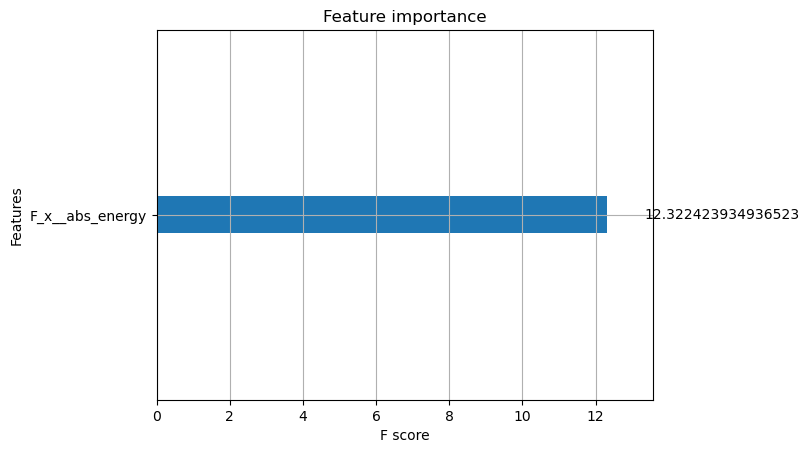

In [37]:
xgb.plot_importance(xgb_clf, importance_type = 'gain')
plt.show()

In [38]:
sum(xgb_clf.feature_importances_ != 0) #Fx 값의 abs energy 특징만이 유의미함, 해당 feature 만으로 고장 유무 판별

1

In [39]:
from sklearn.metrics import classification_report

In [40]:
classification_report(y_test, xgb_clf.predict(comprehensive_features_test), target_names = ['true', 'false'], output_dict = True)

{'true': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 16.0},
 'false': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5.0},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21.0},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21.0}}

- precision: 정밀도 = 예측이 True라고 한 것 중 실제 True인 비율 (false의 경우 반대)
- recall: 재현율 = 실제 True 중 모델이 맞춘 비율 (false의 경우 반대)
- f1-score: 정밀도와 재현율의 조화 평균
- support: 각 클래스의 실제 데이터 수

In [41]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression() 
logistic.fit(comprehensive_features_train, y_train)

LogisticRegression()

In [42]:
comprehensive_features_test.head()

F_x__variance_larger_than_standard_deviation  F_x__has_duplicate_max  \
1                                           0.0                     0.0   
2                                           0.0                     1.0   
3                                           0.0                     0.0   
4                                           0.0                     1.0   
5                                           0.0                     0.0   

   F_x__has_duplicate_min  F_x__has_duplicate  F_x__sum_values  \
1                     1.0                 1.0            -14.0   
2                     1.0                 1.0            -13.0   
3                     1.0                 1.0            -10.0   
4                     1.0                 1.0             -6.0   
5                     0.0                 1.0             -9.0   

   F_x__abs_energy  F_x__mean_abs_change  F_x__mean_change  \
1             14.0              0.142857          0.000000   
2             25.0              1.000000          0.000000   
3             12.0              0.714286          0.000000   
4             16.0              1.214286         -0.071429   
5             17.0              0.928571         -0.071429   

   F_x__mean_second_derivative_central  F_x__median  ...  \
1                            -0.038462         -1.0  ...   
2                            -0.038462         -1.0  ...   
3                            -0.038462         -1.0  ...   
4                            -0.038462          0.0  ...   
5                             0.038462         -1.0  ...   

   T_z__fourier_entropy__bins_5  T_z__fourier_entropy__bins_10  \
1                      1.073543                       1.440235   
2                      1.073543                       1.494175   
3                      1.386294                       1.732868   
4                      1.073543                       1.494175   
5                      0.900256                       1.320888   

   T_z__fourier_entropy__bins_100  \
1                        2.079442   
2                        2.079442   
3                        2.079442   
4                        2.079442   
5                        2.079442   

   T_z__permutation_entropy__dimension_3__tau_1  \
1                                     -0.000000   
2                                      0.937156   
3                                      1.265857   
4                                      1.156988   
5                                      1.156988   

   T_z__permutation_entropy__dimension_4__tau_1  \
1                                     -0.000000   
2                                      1.234268   
3                                      1.704551   
4                                      1.907284   
5                                      1.863680   

   T_z__permutation_entropy__dimension_5__tau_1  \
1                                     -0.000000   
2                                      1.540306   
3                                      2.019815   
4                                      2.397895   
5                                      2.271869   

   T_z__permutation_entropy__dimension_6__tau_1  \
1                                     -0.000000   
2                                      1.748067   
3                                      2.163956   
4                                      2.302585   
5                                      2.302585   

   T_z__permutation_entropy__dimension_7__tau_1  \
1                                     -0.000000   
2                                      1.831020   
3                                      2.197225   
4                                      2.197225   
5                                      2.197225   

   T_z__query_similarity_count__query_None__threshold_0.0  \
1                                                0.0        
2                                                0.0        
3                                                0.0        
4                     

In [43]:
logistic.score(comprehensive_features_test, y_test)

0.5714285714285714

In [44]:
classification_report(y_test, logistic.predict(comprehensive_features_test), target_names=['true', 'false'], output_dict=True) 

{'true': {'precision': 1.0,
  'recall': 0.4375,
  'f1-score': 0.6086956521739131,
  'support': 16.0},
 'false': {'precision': 0.35714285714285715,
  'recall': 1.0,
  'f1-score': 0.5263157894736842,
  'support': 5.0},
 'accuracy': 0.5714285714285714,
 'macro avg': {'precision': 0.6785714285714286,
  'recall': 0.71875,
  'f1-score': 0.5675057208237986,
  'support': 21.0},
 'weighted avg': {'precision': 0.846938775510204,
  'recall': 0.5714285714285714,
  'f1-score': 0.5890813991500491,
  'support': 21.0}}

select_features 테스트 해보기

지속 error가 발생 
(처음엔 인덱스가 안맞고, 그 다음엔 true,false 값이 부족하며, 그다음 길이 불일치 등으로 진행 불가.)

In [45]:
comprehensive_features_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, 1 to 34
Columns: 4662 entries, F_x__variance_larger_than_standard_deviation to T_z__mean_n_absolute_max__number_of_maxima_7
dtypes: float64(4662)
memory usage: 765.0 KB


In [46]:
y_test.info()

<class 'pandas.core.series.Series'>
Index: 21 entries, 2 to 35
Series name: None
Non-Null Count  Dtype
--------------  -----
21 non-null     bool 
dtypes: bool(1)
memory usage: 189.0 bytes


In [47]:
y_test.head()

2    True
3    True
4    True
5    True
6    True
dtype: bool

In [49]:
from sklearn.model_selection import StratifiedShuffleSplit

def stratified_split(x, y, test_size=0.3, random_state=42):
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    for train_idx, test_idx in sss.split(np.zeros(len(y)), y):
        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]
        X_train = x[x['id'].isin(y_train.index)]
        X_test = x[x['id'].isin(y_test.index)]
        return X_train, y_train, X_test, y_test

In [50]:
X_train, y_train, X_test, y_test = stratified_split(timeseries, y) 

In [51]:
comprehensive_features_train2 = extract_features(
                                X_train,
                                column_id="id",
                                column_sort="time",
                                default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


In [52]:
comprehensive_features_test2 = extract_features(
                                X_test,
                                column_id="id",
                                column_sort="time",
                                default_fc_parameters=settings)

Feature Extraction: 100%|██████████| 18/18 [00:09<00:00,  1.90it/s]


In [53]:
impute(comprehensive_features_train2)

c:\Users\User\anaconda3\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


F_x__variance_larger_than_standard_deviation  F_x__has_duplicate_max  \
1                                            0.0                     0.0   
3                                            0.0                     0.0   
5                                            0.0                     0.0   
6                                            1.0                     1.0   
7                                            0.0                     1.0   
..                                           ...                     ...   
84                                           1.0                     1.0   
85                                           1.0                     0.0   
86                                           1.0                     0.0   
87                                           1.0                     1.0   
88                                           1.0                     0.0   

    F_x__has_duplicate_min  F_x__has_duplicate  F_x__sum_values  \
1                      1.0                 1.0            -14.0   
3                      1.0                 1.0            -10.0   
5                      0.0                 1.0             -9.0   
6                      1.0                 1.0            -15.0   
7                      0.0                 1.0            -13.0   
..                     ...                 ...              ...   
84                     0.0                 1.0          -1073.0   
85                     1.0                 1.0            143.0   
86                     0.0                 0.0            961.0   
87                     0.0                 1.0           4509.0   
88                     1.0                 1.0           -143.0   

    F_x__abs_energy  F_x__mean_abs_change  F_x__mean_change  \
1              14.0              0.142857          0.000000   
3              12.0              0.714286          0.000000   
5              17.0              0.928571         -0.071429   
6              39.0              1.714286          0.142857   
7              21.0              0.928571          0.214286   
..              ...                   ...               ...   
84          96833.0              7.142857         -5.428571   
85           1683.0              1.357143          1.071429   
86          83497.0              9.071429          9.071429   
87        1405437.0             12.928571         12.214286   
88           1427.0              0.785714         -0.500000   

    F_x__mean_second_derivative_central  F_x__median  ...  \
1                             -0.038462         -1.0  ...   
3                             -0.038462         -1.0  ...   
5                              0.038462         -1.0  ...   
6                              0.153846         -1.0  ...   
7                             -0.076923         -1.0  ...   
..                                  ...          ...  ...   
84                            -0.038462        -98.0  ...   
85                             0.076923          8.0  ...   
86                             0.807692         52.0  ...   
87                            -1.038462        338.0  ...   
88                             0.038462         -9.0  ...   

    T_z__fourier_entropy__bins_5  T_z__fourier_entropy__bins_10  \
1                       1.056632                       1.353591   
3                       1.386294                       1.732868   
5                       0.900256                       1.320888   
6                       0.974315                       1.213008   
7                       1.255482                       1.494175   
..                           ...                            ...   
84                      0.735622                       0.735622   
85                      0.735622                       0.735622   
86                      0.735622                       1.073543   
87                      0.735622                       0.735622   
88                      1.255482                       1.49

In [54]:
impute(comprehensive_features_test2)

c:\Users\User\anaconda3\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['T_x__partial_autocorrelation__lag_7'
 'T_x__partial_autocorrelation__lag_8'
 'T_x__partial_autocorrelation__lag_9' ...
 'F_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'F_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'F_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


T_x__variance_larger_than_standard_deviation  T_x__has_duplicate_max  \
2                                            1.0                     1.0   
4                                            1.0                     1.0   
10                                           0.0                     1.0   
12                                           1.0                     0.0   
14                                           1.0                     0.0   
18                                           1.0                     0.0   
20                                           1.0                     0.0   
21                                           1.0                     1.0   
29                                           1.0                     0.0   
33                                           1.0                     0.0   
37                                           1.0                     0.0   
39                                           1.0                     0.0   
40                                           1.0                     0.0   
42                                           1.0                     0.0   
44                                           1.0                     0.0   
50                                           1.0                     1.0   
56                                           1.0                     1.0   
59                                           1.0                     0.0   
60                                           1.0                     0.0   
64                                           1.0                     1.0   
73                                           1.0                     0.0   
74                                           1.0                     0.0   
77                                           1.0                     0.0   
78                                           1.0                     0.0   
79                                           1.0                     0.0   
80                                           1.0                     0.0   
82                                           1.0                     0.0   

    T_x__has_duplicate_min  T_x__has_duplicate  T_x__sum_values  \
2                      1.0                 1.0            -53.0   
4                      0.0                 1.0            -93.0   
10                     1.0                 1.0            -38.0   
12                     0.0                 1.0            -59.0   
14                     0.0                 1.0            -84.0   
18                     0.0                 1.0           -171.0   
20                     0.0                 1.0           -246.0   
21                     0.0                 1.0           -196.0   
29                     0.0                 1.0           -130.0   
33                     0.0                 1.0            -96.0   
37                     0.0                 1.0          -2405.0   
39                     0.0                 1.0           -259.0   
40                     0.0                 1.0          -1081.0   
42                     0.0                 1.0           -409.0   
44                     0.0                 1.0           -519.0   
50                     0.0                 1.0           -614.0   
56                     0.0                 1.0           -506.0   
59                     0.0                 1.0            194.0   
60                     0.0                 0.0           1247.0   
64                     0.0                 1.0          -2782.0   
73                     0.0                 0.0          -1872.0   
74                     0.0                 1.0          -6188.0   
77                     0.0                 1.0             89.0   
78                     0.0                 1.0           1145.0   
79                     0.0                 1.0           2568.0   
80                     0.0                 1.0            132.0   
82                     0.0                 0.0            409.0   

In [55]:
# 더 줄여보기
from tsfresh import select_features
filtered_features_train = select_features(comprehensive_features_train2, y_train)


In [56]:
# 인덱스를 맞춰서 에러 방지
y_test_aligned = y_test.reindex(comprehensive_features_test.index)

# 더 줄여보기
from tsfresh import select_features
# filtered_features_test = select_features(comprehensive_features_test, y_test_aligned)

filtered_features_test = comprehensive_features_test[filtered_features_train.columns]


In [ ]:
# rf_clf.fit(filtered_features_train, y_train)
# rf_clf.score(filtered_features_test, y_test) # 값 불일치 error 해결 실패

추가 시각화

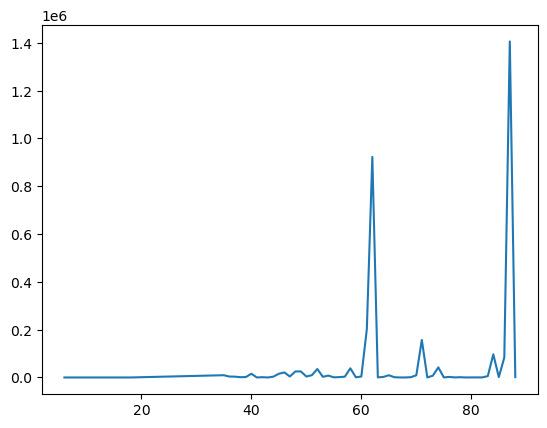

In [59]:
plt.figure()
plt.plot(comprehensive_features_train['F_x__abs_energy']) 

In [66]:
comprehensive_features_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67 entries, 6 to 88
Columns: 4662 entries, F_x__variance_larger_than_standard_deviation to T_z__mean_n_absolute_max__number_of_maxima_7
dtypes: float64(4662)
memory usage: 2.4 MB


In [67]:
test = []
test = pd.DataFrame(test)
test['F_x__abs_energy'] = comprehensive_features_train['F_x__abs_energy'].loc[6:88]
test['target'] = y.loc[6:88]
test.tail(28)

F_x__abs_energy  target
61         201785.0   False
62         922696.0   False
63            359.0   False
64           2277.0   False
65           9345.0   False
66           1167.0   False
67            106.0   False
68             62.0    True
69           1129.0   False
70           9413.0   False
71         156905.0   False
72            103.0   False
73           7512.0   False
74          42365.0   False
75            280.0   False
76           2354.0   False
77            303.0   False
78           1156.0   False
79             75.0   False
80            325.0   False
81            342.0   False
82            275.0   False
83           5841.0   False
84          96833.0   False
85           1683.0   False
86          83497.0   False
87        1405437.0   False
88           1427.0   False

그래프상 60 구간이나 80 구간에 높게 뛰는 부분이 이상치일 것으로 판단되지만 고장 여부와는 무관한 것으로 추정

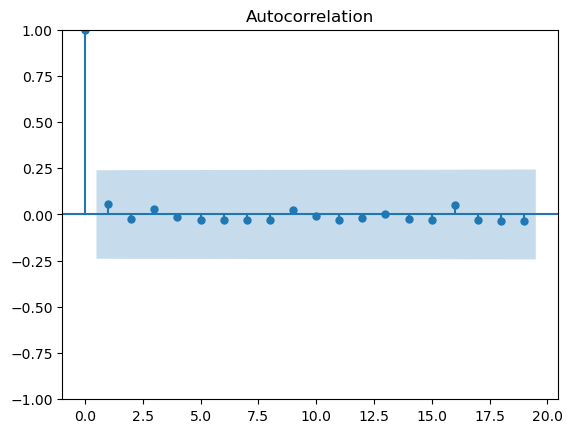

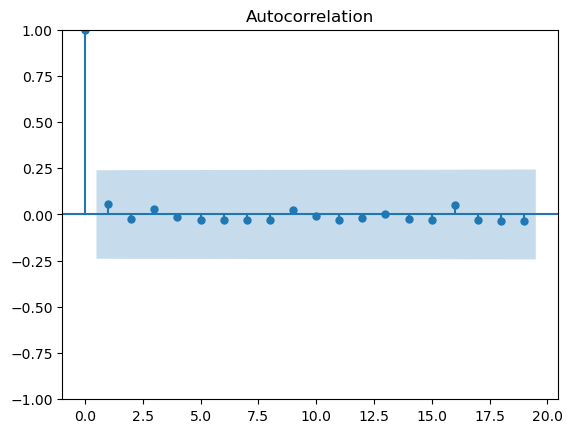

In [62]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(comprehensive_features_train['F_x__abs_energy'])

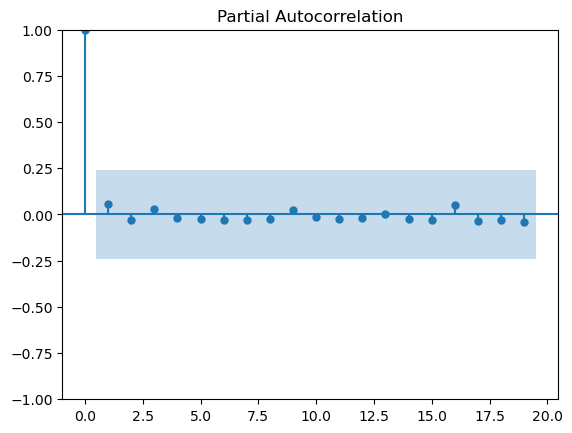

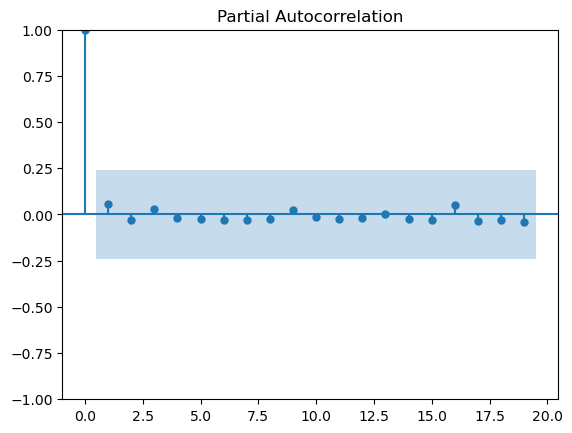

In [63]:
plot_pacf(comprehensive_features_train['F_x__abs_energy'])

대부분의 lag에서 파란 점이 신뢰 구간(95%) 안에 들어가 있어 해당 시점(lag)과는 유의미한 자기상관이 없다는 의미   
즉, 다른 시점과의 구조적인 시간 의존성이 없음

<Axes: xlabel='target', ylabel='F_x__abs_energy'>

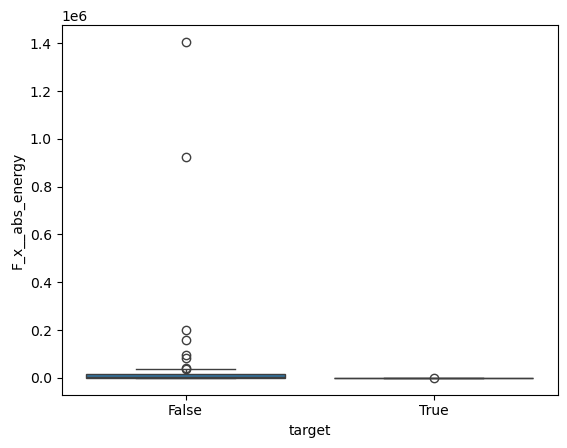

In [68]:
import seaborn as sns
sns.boxplot(data=test, x='target', y='F_x__abs_energy')

In [ ]:
test2 = test.copy()
test2['F_x__abs_energy'] = test2['F_x__abs_energy'].apply(lambda x: 1000 if x > 1000 else x) 

<Axes: xlabel='target', ylabel='F_x__abs_energy'>

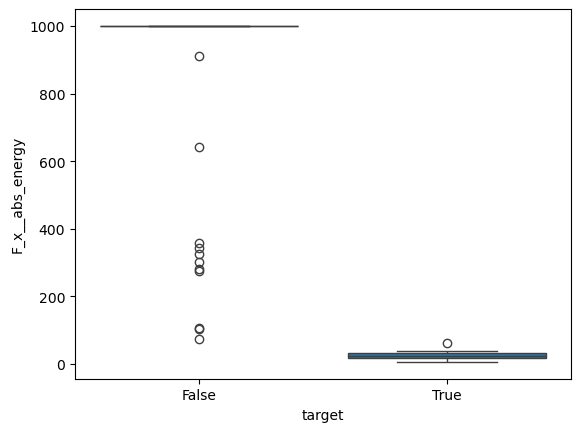

In [92]:
import seaborn as sns
sns.boxplot(data=test2, x='target', y='F_x__abs_energy')

In [87]:
test2[test2['target']== True]

F_x__abs_energy  target
6              39.0    True
7              21.0    True
8              26.0    True
9              24.0    True
10             14.0    True
11             25.0    True
12             30.0    True
13             31.0    True
14             17.0    True
15             33.0    True
16             33.0    True
17             22.0    True
18             17.0    True
41              6.0    True
43             10.0    True
68             62.0    True

energy 값을 500 이상을 500 으로 변경했더니 box plot으로 해석 가능한 그래프가 그려지지 않음. 
box plot에 대한 이해를 더 높여야할 듯 함.